In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
url = 'https://github.com/zozunin/project/blob/main/HW_2_v13.xls?raw=true'
cols = ['Возраст (лет)', 'Количество иждивенцев',	'Доход (руб./мес.)',	'Срок проживания в регионе (лет)',	'Оценка автомобиля заемщика (USD)',	'Размер кредита(тыс. руб.)']
X = pd.read_excel(url, header=None)
X.columns = cols
X.head(10)

,Возраст (лет),Количество иждивенцев,Доход (руб./мес.),Срок проживания в регионе (лет),Оценка автомобиля заемщика (USD),Размер кредита(тыс. руб.)
0,37,1,7400,9,7000,70000
1,45,3,33100,12,34000,337000
2,32,1,18700,5,17000,176000
3,39,2,29100,9,29000,289000
4,33,1,11400,6,10000,104000
5,28,1,20100,2,18000,184000
6,47,2,4400,15,6000,55000
7,36,2,30500,7,30000,299000
8,45,3,32300,12,33000,330000
9,39,2,25900,9,26000,258000


## Изучение данных

## PCA

- Выполнить центрирование данных и такую нормировку, что евклидова норма каждого признака равна 1 (полученная матрица обозначается через Z).

In [3]:
# центрирование и нормализация
Z = X - X.mean()
norms = [np.linalg.norm(Z[i]) for i in Z.columns]
Z = Z/norms

In [4]:
np.linalg.norm(Z['Возраст (лет)'])

1.0

- Найти SVD разложение матрицы Z (матрицы U, S, V). **Докажите, что при выбранной нормировке, коэффициенты разложения столбцов матрицы Z по скрытым факторам являются корреляциями этих столбцов и скрытых факторов.**

In [5]:
U, S, VT = np.linalg.svd(Z)

 - Исследуйте, сколько скрытых факторов (главные факторы) достаточно для хорошей аппроксимации матрицы данных Z. Заменить значения исходных признаков линейными комбинациями главных факторов (матрица Zk, k – число главных факторов). Оценить погрешность аппроксимации в евклидовой матричной  норме и норме Фробениуса. 

In [6]:
percentvar = [round(i/6.0*100,2) for i in S**2]
print("Сингулярные числа: ", S.round(2))
qrS = S ** 2
print("Квадраты сингулярных чисел: ", qrS.round(2))
percentvar = [round(i/6.0*100, 2) for i in qrS]
print("Вклад в вариацию данных в %: ", percentvar)
print("Два главных фактора вносят {}% в вариацию данных".format(sum(percentvar[:2])))

#||A −Ak||2 = σk+1
print("Ошибка аппроксимации в евклидовой матричной норме, где k=2: ", round(S[2], 2))
 
# ||A −Ak||2F = σ2k+1 + ... + σ2p
fr_error = round(sum(S[2:]**2),2)
print("Ошибка аппроксимации в норме Фробениуса, где k=2: ", fr_error)

"""|Z −Zk||2F / ||Z||2F
= (s2k+1 + s2k+2 + ... + s2p)/
s21 + s22 + ... + s2k + s2k+1 + ... + s2p"""
rel_fr_error = round(sum(S[2:]**2)/sum(S**2)*100, 2)
# или 100 - 98.9
print("Относительная ошибка аппроксимации в норме Фробениуса, где k=2: {}%".format(rel_fr_error))

Сингулярные числа:  [1.84 1.6  0.24 0.07 0.03 0.01]
Квадраты сингулярных чисел:  [3.38 2.55 0.06 0.01 0.   0.  ]
Вклад в вариацию данных в %:  [56.39, 42.51, 0.99, 0.09, 0.02, 0.0]
Два главных фактора вносят 98.9% в вариацию данных
Ошибка аппроксимации в евклидовой матричной норме, где k=2:  0.24
Ошибка аппроксимации в норме Фробениуса, где k=2:  0.07
Относительная ошибка аппроксимации в норме Фробениуса, где k=2: 1.1%


In [9]:
# заменяем признаки двумя
SVT = np.dot(np.diag(S[:2]), VT[:2])
Zk = np.dot(U.T[:2].T,SVT)
#Zk = np.dot(U.T[:2].T, np.diag(S[:2])), VT[:2])

- Сравнить матрицы корреляций признаков для матрицы Z и матрицы Zk. Оценить качество аппроксимации по близости матриц корреляций (можно использовать относительную погрешность в одной из матричных норм) 

In [10]:
corrZ = Z.corr()
Zkdf = pd.DataFrame(Zk, columns = Z.columns )
corrZk = Zkdf.corr()

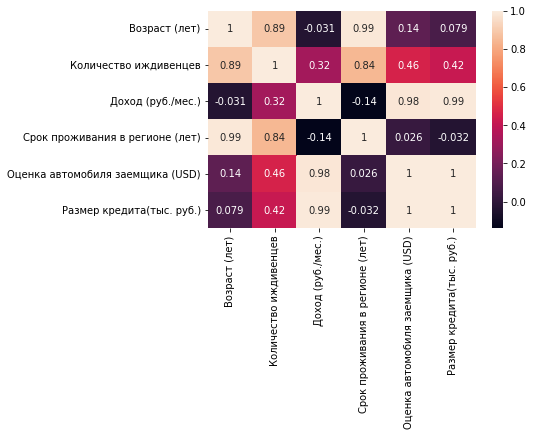

In [11]:
sns.heatmap(corrZ,annot=True)

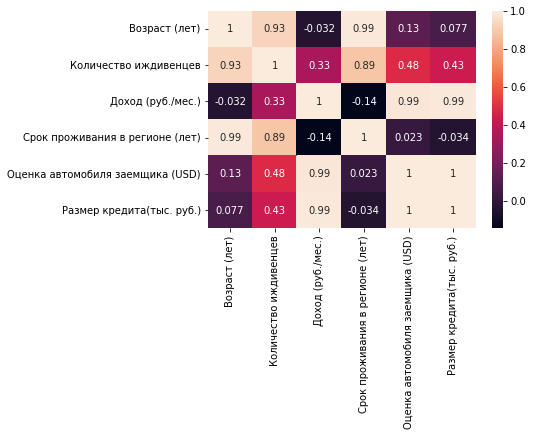

In [12]:
sns.heatmap(corrZk,annot=True)

In [13]:
np.linalg.norm(corrZ, 'fro') - np.linalg.norm(corrZ, 'fro')

4.237354850246774

Матрицы нагрузок и вращение

In [ ]:
VT[:2].T # карта признаков

array([[ 0.31027213, -0.51019506],
       [ 0.44262039, -0.34078805],
       [ 0.43491699,  0.37524008],
       [ 0.25912528, -0.5465919 ],
       [ 0.48246293,  0.28714921],
       [ 0.46770633,  0.31865656]])

Получим матрицу нагрузок:

In [ ]:
SVT.T

array([[ 0.57070095, -0.81480509],
       [ 0.81413655, -0.54425426],
       [ 0.79996724,  0.59927575],
       [ 0.47662369, -0.87293252],
       [ 0.88742117,  0.45859056],
       [ 0.86027853,  0.50890925]])

Ясной картины нагрузки не дают, поэтому будем вращать.

Попробуем три способа:
1. простой поворот на 45 градусов
2. варимакс
3. квартимакс

In [ ]:
G = np.array([[0.71, -0.71], [0.71, 0.71]]) # 45 градусов по часовой
simple_rot = np.dot(G.T, SVT)
simple_rot.T

array([[-0.17331394, -0.98370929],
       [ 0.19161643, -0.96445747],
       [ 0.99346252, -0.14249096],
       [-0.28137927, -0.95818491],
       [ 0.95566833, -0.30446974],
       [ 0.97212333, -0.24947219]])

После простого поворота корреляции стали значительно виднее. 
* от первого фактора: 3, 5, 6
* от второго фактора: 1, 2, 4

In [ ]:
! pip install factor_analyzer
from factor_analyzer import Rotator

После применения метода варимакс получаем недостаточно четкие результаты по 6 признаку, в остальном - совпадает с простым поворотом на 45 градусов.

In [ ]:
loadings = pd.DataFrame(SVT.T)
varirot = Rotator(method='varimax')
varimax_rot = varirot.fit_transform(loadings)
varimax_rot

array([[ 3.40243576e-04, -9.94789822e-01],
       [ 3.54915907e-01, -9.12724340e-01],
       [ 9.99018708e-01,  3.22588524e-02],
       [-1.10065150e-01, -9.88466991e-01],
       [ 9.89996713e-01, -1.33147067e-01],
       [ 9.96612829e-01, -7.63586776e-02]])

Квартимакс дает самые однозначные результаты:
* от первого фактора: 3, 5, 6
* от второго фактора: 1, 2, 4

In [ ]:
quartirot = Rotator(method='quartimax')
quartimax_rot = quartirot.fit_transform(loadings)
quartimax_rot

array([[ 0.00987027, -0.99474091],
       [ 0.36364348, -0.90928238],
       [ 0.99866383,  0.04182793],
       [-0.10059063, -0.98947605],
       [ 0.99122683, -0.12365683],
       [ 0.99729861, -0.06680767]])

In [ ]:
# переход к другому базису
Zk2 = np.dot( np.dot(U.T[:2].T, G), simple_rot)



- Используя выделенные главные факторы, найти представления клиентов векторами меньшей размерности (размерности k).
- Используя представление клиентов векторами меньшей размерности, построить карту клиентов. Сделать выводы о клиентах банка. 
